In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

In [2]:
amazon = pd.read_csv('AmazonReview.csv')
print(amazon.shape)

(5000, 9)


In [3]:
from sklearn.model_selection import train_test_split

raw_data_train, raw_data_test, y_labeled, y_labeled = train_test_split(amazon, amazon['helpful'], test_size= 0.2, random_state=927)

In [4]:
raw_data_train.to_csv('raw_data_train.csv', index=False)
raw_data_test.to_csv('raw_data_test.csv', index=False)
y_labeled.to_csv('y_labeled.csv')
y_labeled.to_csv('y_labeled.csv')

In [5]:
amazonTrain = pd.read_csv('raw_data_train.csv')
print(amazonTrain.shape)
type(amazonTrain.Text)

(4000, 9)


pandas.core.series.Series

In [6]:
s = pd.Series([amazon])
raw = s.to_string()
type(raw)

str

#### Taking Summaries and Comments from the documents as key features to do word analysis
#### Taking out stopwords, case differences, and punctuation
#### using hash vectorizer and tfidf tranformation to convert words into matrix

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', token_pattern='(?u)\b\w\w+\b', n_features= 2*17, analyzer='word', norm='l1', non_negative=False)
X_hv = hv.fit_transform(amazonTrain.Text)
print(X_hv.shape)

(4000, 34)


In [8]:
joblib.dump(hv, 'hv.pkl')

['hv.pkl']

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm='l1', sublinear_tf=True)
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer
corpusSum = amazonTrain.Summary.values.astype('U')
sums = HashingVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', token_pattern='(?u)\b\w\w+\b', n_features= 2*17, analyzer='word', norm=None, non_negative=False)
X_sums = sums.fit_transform(corpusSum)
print(X_sums.shape)

(4000, 34)


In [11]:
joblib.dump(sums, 'hvsum.pkl')

['hvsum.pkl']

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm='l1', sublinear_tf=True)
X_tfidf_sum = transformer.fit_transform(X_sums)

joblib.dump(transformer, 'transformer_sum.pkl') # pickle

['transformer_sum.pkl']

#### Also considering the length of each summary and comment to eveluate the helpfulness

In [13]:
amazonTrain['reviewLen'] = amazonTrain['Text'].str.len()
amazonTrain['sumLen'] = amazonTrain['Summary'].str.len().replace(np.nan,0)


X_length_features = amazonTrain[["reviewLen","sumLen"]]

#### Combining feature matrix

In [14]:
#Combine words matrix
from scipy.sparse import csr_matrix, hstack
X_combined = hstack([X_tfidf,X_tfidf_sum])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(4000, 68)


In [15]:
from scipy.sparse import csr_matrix, hstack
X_length_features_csr = csr_matrix(X_length_features)
X_combined = hstack([X_matrix, X_length_features_csr])
X_feature = csr_matrix(X_combined) 
print(X_feature.shape)

(4000, 70)


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_feature)
print(X.shape)

joblib.dump(sc, 'sc.pkl')

(4000, 70)


['sc.pkl']

#### Create y

In [17]:
y = amazonTrain['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### Testing different modules on the training set

### nbs

In [18]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 3815, 'Neg': 185, 'TP': 3815, 'TN': 0, 'FP': 185, 'FN': 0, 'Accuracy': 0.95375, 'Precision': 0.95375, 'Recall': 1.0, 'desc': 'nbs'}


### ols

In [19]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 3815, 'Neg': 185, 'TP': 3815, 'TN': 1, 'FP': 184, 'FN': 0, 'Accuracy': 0.954, 'Precision': 0.953988497124281, 'Recall': 1.0, 'desc': 'ols'}


C:\Users\xyche\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


#### randomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=7, min_samples_split=9, min_samples_leaf=1, min_weight_fraction_leaf=0.5, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.1, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=27, verbose=0, warm_start=False, class_weight=None)
rf.fit(X, y)
joblib.dump(rf, 'rf.pkl') # pickle

rf_performance = BinaryClassificationPerformance(rf.predict(X), y, 'rf')
rf_performance.compute_measures()
print(rf_performance.performance_measures)

{'Pos': 3815, 'Neg': 185, 'TP': 3815, 'TN': 0, 'FP': 185, 'FN': 0, 'Accuracy': 0.95375, 'Precision': 0.95375, 'Recall': 1.0, 'desc': 'rf'}


#### rdg

In [21]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=5.0)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 3815, 'Neg': 185, 'TP': 3815, 'TN': 0, 'FP': 185, 'FN': 0, 'Accuracy': 0.95375, 'Precision': 0.95375, 'Recall': 1.0, 'desc': 'rdg'}


#### dtc

In [22]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort=False)
dtc.fit(X, y)
joblib.dump(dtc, 'dtc.pkl') # pickle

dtc_performance = BinaryClassificationPerformance(dtc.predict(X), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 3815, 'Neg': 185, 'TP': 3610, 'TN': 185, 'FP': 0, 'FN': 205, 'Accuracy': 0.94875, 'Precision': 1.0, 'Recall': 0.9462647444298821, 'desc': 'dtc'}


#### Graph on each result

In [23]:
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
%matplotlib inline

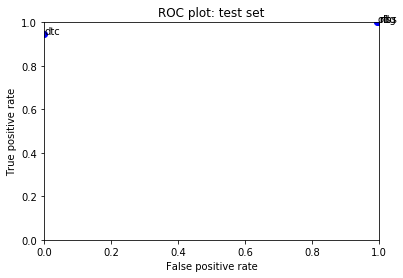

In [24]:
fits = [ols_performance, nbs_performance, dtc_performance, rf_performance, rdg_performance,]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Testing Set on best trained Model

In [25]:
amazonTest = pd.read_csv('raw_data_test.csv')
print(amazonTest.shape)

(1000, 9)


### Feature Tansformation

In [26]:
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazonTest.Text)
#print(X_cv.shape)

In [27]:
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [28]:
corpusSum = amazonTest.Summary.values.astype('U')
hvsum = joblib.load('hvsum.pkl')
X_hvsum = hvsum.transform(corpusSum)
#print(X_cvsum.shape)

In [29]:
transformer_sum = joblib.load('transformer_sum.pkl')
X_tfidf_sum = transformer.transform(X_hvsum)

In [30]:
amazonTest['reviewLen'] = amazonTest['Text'].str.len()
amazonTest['sumLen'] = amazonTest['Summary'].str.len().replace(np.nan,0)


X_length_features = amazonTest[["reviewLen","sumLen"]]

In [31]:
from scipy.sparse import csr_matrix, hstack
X_combined = hstack([X_tfidf,X_tfidf_sum])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(1000, 68)


In [32]:
from scipy.sparse import csr_matrix, hstack
X_length_features_csr = csr_matrix(X_length_features)
X_combined = hstack([X_matrix, X_length_features_csr])
X_feature = csr_matrix(X_combined) 
print(X_feature.shape)

(1000, 70)


In [33]:
sc = joblib.load('sc.pkl')
X = sc.transform(X_feature)
print(X.shape)

(1000, 70)


In [34]:
y = amazonTest['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### Test on the best model dtc

In [35]:
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 950, 'Neg': 50, 'TP': 880, 'TN': 22, 'FP': 28, 'FN': 70, 'Accuracy': 0.902, 'Precision': 0.9691629955947136, 'Recall': 0.9263157894736842, 'desc': 'dtc'}


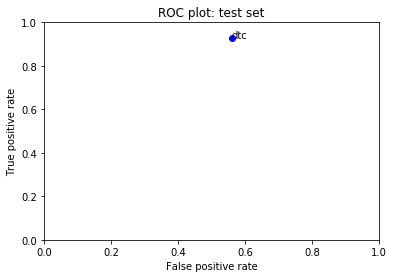

In [36]:
fits = [dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()